In [1]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [2]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [3]:
NUM_CLASSES = 21

# Dataset reading

In [4]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [5]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [8]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 42)                0         
                                                                 
 dense (Dense)               (None, 20)                860       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 21)                231       
                                                                 
Total params: 1,301
Trainable params: 1,301
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [10]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [11]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
116/118 [============================>.] - ETA: 0s - loss: 2.9556 - accuracy: 0.0996
Epoch 1: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
118/118 [==============================] - 2s 5ms/step - loss: 2.9548 - accuracy: 0.0997 - val_loss: 2.7714 - val_accuracy: 0.1606
Epoch 2/1000
103/118 [=========================>....] - ETA: 0s - loss: 2.7004 - accuracy: 0.1498
Epoch 2: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
118/118 [==============================] - 0s 3ms/step - loss: 2.6847 - accuracy: 0.1540 - val_loss: 2.4456 - val_accuracy: 0.3026
Epoch 3/1000
107/118 [==========================>...] - ETA: 0s - loss: 2.4327 - accuracy: 0.2127
Epoch 3: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
118/118 [==============================] - 0s 3ms/step - loss: 2.4225 - accuracy: 0.2159 - val_loss: 2.1382 - val_accuracy: 0.4022
Epoch 4/1000
 94/118 [======================>.......] - ETA: 0s - loss: 2.2324 - accu

In [12]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

40/40 [==============================] - 0s 1ms/step - loss: 0.5454 - accuracy: 0.9152


In [13]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [14]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 79ms/step
[2.42383070e-02 3.84295732e-01 6.04951128e-05 1.25944731e-03
 6.60456493e-02 6.05284702e-03 3.24332534e-04 1.40071308e-04
 7.34079769e-03 8.08594376e-03 2.31116489e-01 1.12338355e-02
 1.07759587e-03 3.15910429e-02 9.22553837e-02 8.23578313e-02
 1.20103583e-02 2.87433788e-02 2.45095998e-05 1.17459539e-02
 6.23992369e-09]
1


# Confusion matrix

157/157 [==============================] - 0s 898us/step


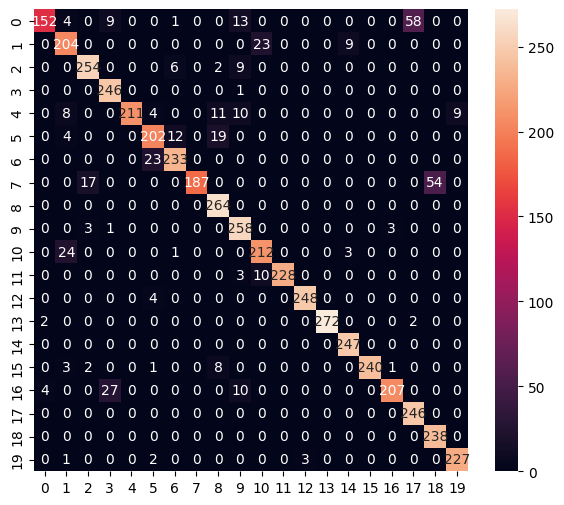

Classification Report
              precision    recall  f1-score   support

           0       0.96      0.64      0.77       237
           1       0.82      0.86      0.84       236
           2       0.92      0.94      0.93       271
           3       0.87      1.00      0.93       247
           4       1.00      0.83      0.91       253
           5       0.86      0.85      0.85       237
           6       0.92      0.91      0.92       256
           7       1.00      0.72      0.84       258
           8       0.87      1.00      0.93       264
           9       0.85      0.97      0.91       265
          10       0.87      0.88      0.87       240
          11       1.00      0.95      0.97       241
          12       0.99      0.98      0.99       252
          13       1.00      0.99      0.99       276
          14       0.95      1.00      0.98       247
          15       1.00      0.94      0.97       255
          16       0.98      0.83      0.90       248
     

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [16]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [17]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\asus\AppData\Local\Temp\tmpya4iagu2\assets


INFO:tensorflow:Assets written to: C:\Users\asus\AppData\Local\Temp\tmpya4iagu2\assets


7292

# Inference test

In [18]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [19]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [20]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [21]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 996 µs


In [22]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[2.4238309e-02 3.8429576e-01 6.0495055e-05 1.2594461e-03 6.6045649e-02
 6.0528414e-03 3.2433253e-04 1.4007119e-04 7.3407944e-03 8.0859410e-03
 2.3111641e-01 1.1233831e-02 1.0775954e-03 3.1591065e-02 9.2255458e-02
 8.2357794e-02 1.2010351e-02 2.8743399e-02 2.4509600e-05 1.1745943e-02
 6.2399357e-09]
1
